### Application of GPcounts on the single-cell RNA-seq data to identify gene-specific branching locations for individual genes. 

This notebook demonstrates how to build a GPcounts model and plot the posterior model fit and posterior branching times. We have used the single-cell RNA-seq of haematopoietic stem cells (HSCs) from mouse <a href="https://pubmed.ncbi.nlm.nih.gov/26627738/" target="_blank" text_decoration=none>(Paul et al., 2015)</a>. The data contain cells that are differentiated into myeloid and erythroid precursor cell types.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
# from IPython.display import display

### Data description

Slingshot algorithm <a href="https://pubmed.ncbi.nlm.nih.gov/29914354/" target="_blank">(Street et al., 2018)</a> has been used to get trajectory-specific pseudotimes as well as  assignment of cells to different branches. Slingshot infers two lineages for this dataset. The data were derived from the <a href="https://statomics.github.io/tradeSeq/articles/tradeSeq.html" target="_blank">tradeSeq vignette</a>.

The __geneExpression.csv__ file contains the expression profiles of HSCs from mouse.  

The __Slingshot.csv__ file contains lineage-specific cell assignments as well as pseudotimes.

In [2]:
data = pd.read_csv('../data/MouseHSC/geneExpression.csv', index_col=[0]).T
slingShot = pd.read_csv('../data/MouseHSC/Slingshot.csv', index_col=[0])

In [3]:
data.head()

,Mpo,Ly6e,Car1,Car2,Prtn3,Gstm1,Irf8,Erp29,Ctsg,Elane,Apoe,Calr,Klf1,Actb,Cfl1,Sod1,Ran,Vamp5,Alas1
W31105,0,1,1,1,1,2,0,0,0,0,1,1,0,2,1,0,0,0,0
W31106,95,19,2,0,60,7,3,8,9,56,2,30,2,27,15,5,3,1,9
W31107,8,9,51,46,3,1,0,2,0,2,1,9,10,52,10,11,5,1,0
W31108,124,15,4,4,95,11,0,3,54,73,0,75,1,50,10,2,6,3,18
W31109,12,10,41,54,1,0,0,4,4,1,0,11,5,55,9,15,8,3,0


In [4]:
slingShot.head()

,curve1,curve2,pseudotime
W31105,1.0,1.0,0.036348
W31106,1.0,0.0,0.840813
W31107,0.0,1.0,0.759424
W31108,1.0,0.0,0.997455
W31109,0.0,1.0,0.766015


Slingshot assigns a weight to each cell indicating the assignment of cells to different branches. We have used assignment probability 0.80 to determine the cells belong to a specific branch (1 or 2) .

In [5]:
cell_label = np.ones(slingShot.shape[0]) * 2
for i in range(0, slingShot.shape[0]):
    if slingShot.values[i, 0] > 0.8:
        cell_label[i] = 1

### Fit GPcounts model for branching

We have shown examples using both the Negative binomial and the Gaussian likelihood

### Negative bionomial likelihood

In [6]:
from GPcounts.GPcounts_Module import Fit_GPcounts
def Fit_GPcounts_for_branching(geneName, likelihood='Negative_binomial', bins_num=50, ns=5):
    X = slingShot[1::ns][['pseudotime']] 
    Y = data[1::ns][[geneName]].T
    gp_counts = Fit_GPcounts(X,Y)
    d = gp_counts.Infer_branching_location(cell_label[1::ns], bins_num=bins_num, lik_name=likelihood)
    del gp_counts
    return d
d = Fit_GPcounts_for_branching('Mpo', bins_num=25)

  0%|                                                     | 0/1 [00:00<?, ?it/s]2022-02-01 11:01:31.019012: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-01 11:01:31.084883: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.84s/it]


#### plot the posterior model fit and posterior branching times

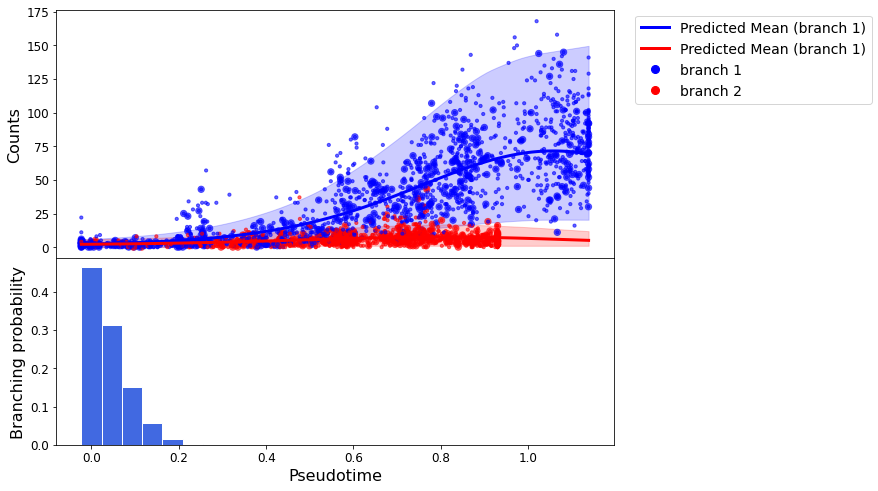

In [7]:
from helper import plotBranching, plotGene
fig, ax = plotBranching(d)
plotGene(ax[0], X=slingShot[['pseudotime']], Y=data[['Mpo']].T, label=cell_label, size=10, alpha=.6)

### Gaussian likelihood

In [8]:
geneName = 'Mpo'
d = Fit_GPcounts_for_branching(geneName, 'Gaussian', bins_num=25)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


#### plot the posterior model fit and posterior branching times

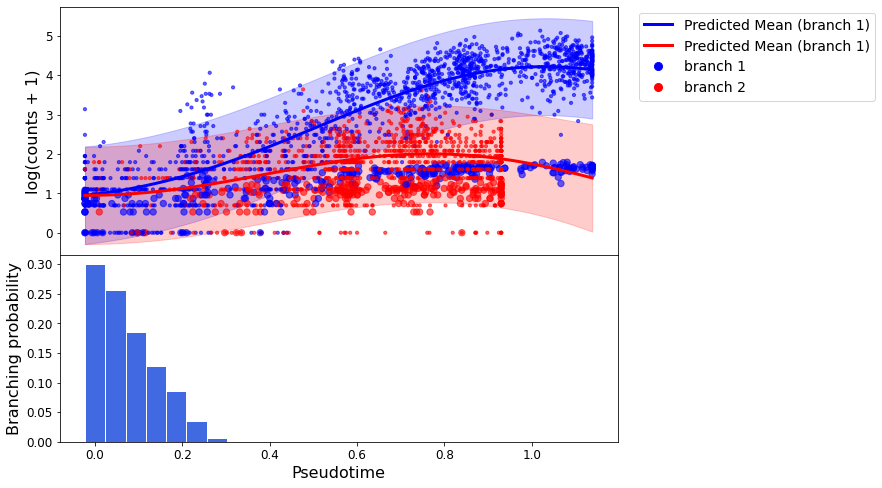

In [9]:
ig, ax = plotBranching(d)
plotGene(ax[0], X=slingShot[['pseudotime']], Y=np.log(data[[geneName]].T + 1), label=cell_label, size=10, alpha=.6)

### Paper results
Uncommenting the following code will reproduce the branching location inference examples demonstrated in the main paper as well as in the supplementary document. It will take more time to run as both the number of genes and the number of bins or test points are larger.

In [10]:
# bins_num = 50
# geneList = ['Mpo', 'Ly6e', 'Car2', 'Car1', 'Ctsg', 'Prtn3', 'Irf8', 'Erp29', 'Apoe']
# d_gaussian = list()
# d_nb = list()
# for g in geneList:
#     print(g)
#     d_nb.append(Fit_GPcounts_for_branching(g, likelihood='Negative_binomial', bins_num=bins_num))
#     d_gaussian.append(Fit_GPcounts_for_branching(g, likelihood='Gaussian', bins_num=bins_num))

In [11]:
# for i in range(0, len(geneList)):
#     _, ax = plotBranching(d_nb[i])
#     plotGene(ax[0], X=slingShot[['pseudotime']], Y=data[[geneList[i]]].T, label=cell_label, size=10, alpha=.6)
#     _, ax = plotBranching(d_gaussian[i])
#     plotGene(ax[0], X=slingShot[['pseudotime']], Y=np.log(data[[geneList[i]]].T + 1), label=cell_label, size=10, alpha=.6)